In [1]:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as int
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm


#import Networkx as net
import Plot3D as plot3d
import dataframe as dataframe

#### Neural Ode

In [2]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)



In [3]:
class nonauto_neural_ode(Simple_FeedforwardNN):
    def __init__(self, variables, drivers,  parameter_func, hidden_layers=1, depth_of_layers=10, automous=False):

        if automous == True:
            self.time_variable = 0
        else:
            self.time_variable = 1

        super().__init__(input_dim=variables+drivers+self.time_variable,
                         hidden_layers=hidden_layers,
                         depth=depth_of_layers,
                         output_dim=variables,
                         activation_func=nn.Tanh() )

        self.number_of_features = variables+drivers+self.time_variable
        self.depth              = depth_of_layers #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.drivers            = drivers
        self.variables          = variables

        self.parameter_func     = parameter_func #function giving the evolution of the parameter over time, should return a tensor.


    def forward(self, t, x):
            #non-autonomous function
            r = self.parameter_func(t)

            #Merging time, state, and parameter into single input tensor.
            input = torch.cat((t.unsqueeze(0).unsqueeze(1), x, r.unsqueeze(1)), dim = 1)

            #Forward pass through network
            output = self.network(input)
            return output

#### Generating Data

##### Models

In [4]:
#Lorenz automous lorenz system
class Lorenz:
    def __init__(self, sigma = 10, rho = 28, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

class Lorenz_nonauto:
    def __init__(self, rho, sigma = 10, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho #should be a 1D function of time

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho(t)[0] - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

In [5]:
parameter_func = lambda t: np.array([20.0])

In [6]:
lorenz = Lorenz_nonauto(rho=parameter_func)

In [7]:
lorenz.f(t=0, x=[1.0, 1.0, 1.0])

array([ 0.        , 18.        , -1.66666667])

##### Solving IVP

In [8]:
##
dt = 0.01; tfinal = 3; tstart = 0

In [9]:
output = int.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[1.0, 1.0, 1.0],
                        method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
data1 = output.y


In [10]:
output = int.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[-1.0, -1.0, -1.0],
                        method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
data2 = output.y

In [11]:
data2[:, 1]

array([-1.00960521, -1.1995509 , -0.96279208])

##### Plotting

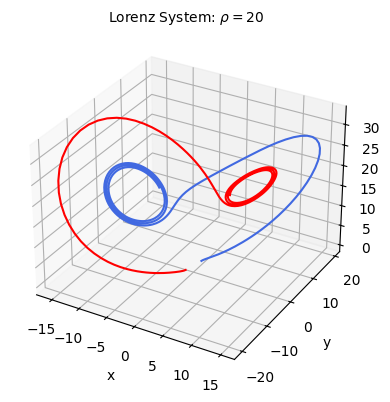

In [12]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))

p2.plot3D(data1, plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k') #+r'$ \sigma = $'+str(sigma)+" "+r'$ \rho = $'+str(rho) )
plt.plot(data2[0, :], data2[1, :], data2[2, :], color='r')


#### Training

##### Normalising Data

In [13]:
np.mean(data1[1])

np.float64(-3.707313353097233)

In [14]:
data1_tensor = torch.tensor(data1)
x_mean = data1_tensor.mean(dim=1)
x_std = data1_tensor.std(dim=1)


x_mean = x_mean.unsqueeze(1); x_std = x_std.unsqueeze(1)
print('Data mean: ', x_mean.squeeze())
print('Data standard deviation: ', x_std.squeeze())

Data mean:  tensor([-3.5190, -3.7073, 17.1181], dtype=torch.float64)
Data standard deviation:  tensor([6.2548, 6.9226, 6.9763], dtype=torch.float64)


In [15]:
data1_norm = (data1_tensor - x_mean)/x_std

##### Normalised Data Plots

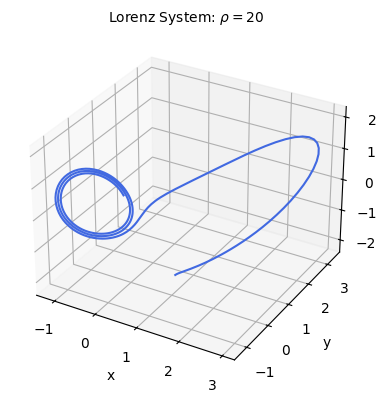

In [16]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))

p2.plot3D(data1_norm, plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k')

##### Setting Parameters

In [157]:
#Setting model, optimiser and loss
parameter_func = lambda t: torch.tensor([20.0])
model = nonauto_neural_ode(variables=3, drivers=1, parameter_func=parameter_func, hidden_layers=2, depth_of_layers=25, automous=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

init = torch.tensor([[1.0, 1.0, 1.0]])
init_norm = (init.T - x_mean)/x_std
init_norm = init_norm.T.float()
t_eval = torch.arange(tstart, tfinal, dt, requires_grad=True)

In [158]:
init_norm

tensor([[ 0.7225,  0.6800, -2.3104]])

In [159]:
#testing network
print(model.network)

x = torch.tensor([[1.0, 2.0, 3.0]], requires_grad=True)
t = torch.tensor(20)
print(model(t, init_norm))

Sequential(
  (0): Linear(in_features=5, out_features=25, bias=True)
  (1): Tanh()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Tanh()
  (4): Linear(in_features=25, out_features=3, bias=True)
)
tensor([[ 1.3767, -0.3137, -0.3778]], grad_fn=<AddmmBackward0>)


##### Batching

In [23]:
data1.shape

(3, 300)

In [160]:
def batch(data, t, batch_length, batch_size):
    data_length = data.shape[0]
    indices = np.random.randint(0, data_length - batch_length, batch_size)
    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[indices[i]:indices[i]+batch_length, :].float())
        batch_time_list.append(t[indices[i]:indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list
        



In [161]:
batch_list, batch_time_list = batch(data1_norm.T, t_eval, batch_length=30, batch_size=5)

In [162]:
batch_time_list[2]

tensor([1.6400, 1.6500, 1.6600, 1.6700, 1.6800, 1.6900, 1.7000, 1.7100, 1.7200,
        1.7300, 1.7400, 1.7500, 1.7600, 1.7700, 1.7800, 1.7900, 1.8000, 1.8100,
        1.8200, 1.8300, 1.8400, 1.8500, 1.8600, 1.8700, 1.8800, 1.8900, 1.9000,
        1.9100, 1.9200, 1.9300], grad_fn=<SliceBackward0>)

##### Training loop

In [163]:
loss_list = []
tgrad_list = []
batch_length = 60; batch_size = 5

In [ ]:
num_epochs = 2000
for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(data1_norm.T, t_eval, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0].unsqueeze(0), batch_time_i, method='rk4', options={'step_size': 0.01})

        #Calculating loss
        loss = loss_fn(pred_x.squeeze(1), torch.tensor(batch_i))
        #loss_list.append(loss.item())

        #batch_time_i.retain_grad()
        #Backpropagation
        loss.backward()
        optimizer.step()
        #tgrad_list.append(torch.mean(abs(batch_time_i.grad)).item())
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                pred_x = odeint(model, init_norm, t_eval, method='rk4', options={'step_size': 0.01})
                train_loss = loss_fn(pred_x.squeeze(1), data1_norm.T)
                loss_list.append(train_loss.item())
                tgrad_list.append(torch.mean(t_eval.grad))
                #print(f"Epoch: {epoch}  training loss {train_loss.item()}")  

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\jackr\AppData\Local\Temp\ipykernel_8856\2520452831.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(pred_x.squeeze(1), torch.tensor(batch_i))
  0%|          | 1/2000 [00:01<35:43,  1.07s/it]

Epoch 0, Loss: 0.0565461322705132


  5%|▌         | 101/2000 [03:05<1:01:39,  1.95s/it]

Epoch 100, Loss: 0.07126724892076738


 10%|█         | 201/2000 [06:24<1:02:18,  2.08s/it]

Epoch 200, Loss: 0.06894556998992862


 15%|█▌        | 301/2000 [10:01<1:04:56,  2.29s/it]

Epoch 300, Loss: 0.04659282047934273


 20%|██        | 401/2000 [13:34<59:07,  2.22s/it]  

Epoch 400, Loss: 0.07269422946184619


 25%|██▌       | 501/2000 [17:06<57:13,  2.29s/it]

Epoch 500, Loss: 0.0694503301597138


 30%|███       | 601/2000 [20:39<53:55,  2.31s/it]

Epoch 600, Loss: 0.19260211176004677


 35%|███▌      | 701/2000 [24:03<38:47,  1.79s/it]

Epoch 700, Loss: 0.10803326361548964


 40%|████      | 801/2000 [28:00<58:11,  2.91s/it]  

Epoch 800, Loss: 0.11105536780587165


 45%|████▌     | 901/2000 [32:22<24:43,  1.35s/it]  

Epoch 900, Loss: 0.2070099278352141


 50%|█████     | 1001/2000 [33:54<17:55,  1.08s/it]

Epoch 1000, Loss: 0.07900803494655176


 55%|█████▌    | 1101/2000 [36:18<39:15,  2.62s/it]

Epoch 1100, Loss: 0.10239320637073537


 60%|██████    | 1201/2000 [40:29<33:55,  2.55s/it]

Epoch 1200, Loss: 0.03491053297811933


 65%|██████▌   | 1301/2000 [44:34<30:15,  2.60s/it]

Epoch 1300, Loss: 0.14279745967245197


 70%|███████   | 1401/2000 [48:40<27:38,  2.77s/it]

Epoch 1400, Loss: 0.04223406580756398


 75%|███████▌  | 1501/2000 [52:41<20:55,  2.52s/it]

Epoch 1500, Loss: 0.04597116280360006


 80%|████████  | 1601/2000 [56:48<17:04,  2.57s/it]

Epoch 1600, Loss: 0.17893844426276262


 85%|████████▌ | 1701/2000 [1:00:14<04:28,  1.11it/s]

Epoch 1700, Loss: 0.14932995557097778


 90%|█████████ | 1801/2000 [1:02:05<08:20,  2.51s/it]

Epoch 1800, Loss: 0.12103790367561347


 95%|█████████▌| 1901/2000 [1:06:12<04:20,  2.63s/it]

Epoch 1900, Loss: 0.035532320129386744


100%|██████████| 2000/2000 [1:10:19<00:00,  2.11s/it]


##### Loss Plot


(0.0, 2.410906766083556)

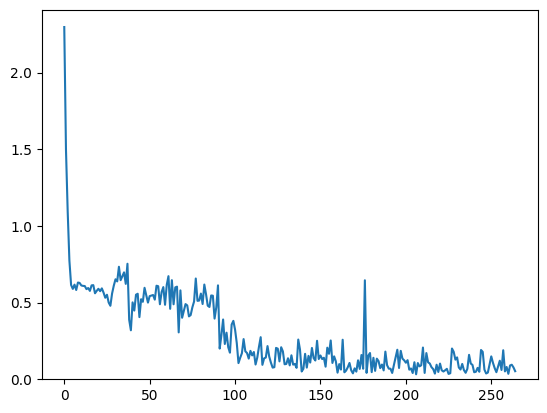

In [195]:
plt.plot(loss_list)
plt.ylim(bottom=0)

In [197]:
torch.mean(t_eval.grad)

tensor(0.0162)

In [186]:
tgrad_list

[tensor(64.0639),
 tensor(64.4534),
 tensor(64.7539),
 tensor(65.0976),
 tensor(65.4571),
 tensor(65.8754),
 tensor(66.1375),
 tensor(66.4281),
 tensor(66.6778),
 tensor(66.9670)]

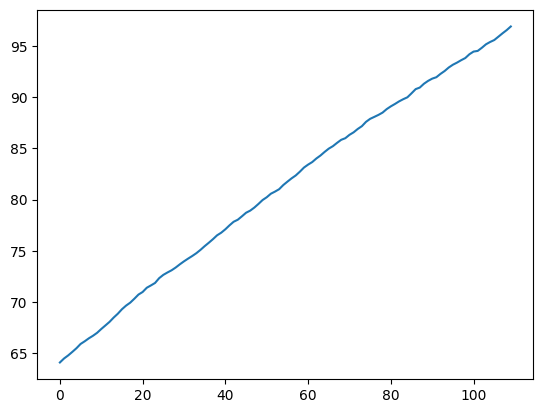

In [196]:
plt.plot(tgrad_list)

In [185]:
torch.mean(t_eval)

tensor(1.4950, grad_fn=<MeanBackward0>)

#### Plotting Model

In [210]:
t_eval_new = torch.arange(0, 5, 0.01)
pred_x = odeint(model, init_norm, t_eval_new, method='rk4', options={'step_size': 0.01})

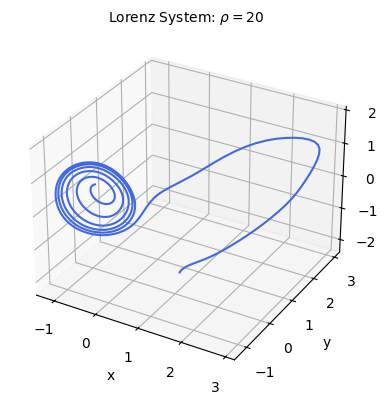

In [211]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))
p2.plot3D(pred_x.T.detach(), plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k')

In [ ]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))

p2.plot3D(data[:, 0, :].T, plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k') #+r'$ \sigma = $'+str(sigma)+" "+r'$ \rho = $'+str(rho) )
plt.plot(data[:, 1, 0], data[:, 1, 1], data[:, 1, 2], color='r')